# volmc demo

In [ ]:
from volmc.models import BlackScholes, Heston, Dupire
from volmc.schemes import Euler, QE
from volmc.types import *
from volmc.options import Call, Put, DigitalCall, DigitalPut, Instrument 

import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt

In [35]:
%matplotlib inline
plt.style.use("dark_background")

## Creating an instrument

In [ ]:
from volmc.options import Instrument, OptionContract, CallPayoff, PutPayoff, Barrier

Instruments can be created from a contract and a payoff :

In [ ]:
contract = OptionContract(K = 110, T = 1.5)

call_option = Instrument(contract, CallPayoff())
put_option = Instrument(contract, PutPayoff())

in_out_payoff = Barrier(H = 120, direction = "up", nature = "out", payoff = CallPayoff())
in_out_call = Instrument(contract, in_out_payoff)

For convenience, some functions allow to rapidely create a predefined instrument :

In [9]:
from volmc.options import Call, Put, DigitalCall, DigitalPut

In [ ]:
call_option = Call(K = 110, T = 1.5)
digital_put = DigitalPut(K = 90, T = 1.5)

## Generating a path

### Parametrize a model

In [15]:
from volmc.models import BlackScholes, Heston, Dupire
from volmc.types import LocalVolatilitySurface

In [ ]:
bs = BlackScholes(mu = 0.02, sigma = 0.2)
heston = Heston(mu = 0.02,
                kappa = 1.5,
                theta = 0.05,
                epsilon = 0.2,
                rho = -0.5)

### Dupire

In [106]:
s = [80, 90, 100, 110, 120]
t = [0.2, 0.4, 0.8, 1.0]
v = [
# S = 80 |  90  | 100 | 110 | 120    t =  
    [0.32, 0.26, 0.22, 0.25, 0.30],  # 0.2
    [0.30, 0.25, 0.21, 0.24, 0.28],  # 0.4
    [0.28, 0.24, 0.20, 0.23, 0.26],  # 0.8
    [0.26, 0.23, 0.19, 0.22, 0.25],  # 1.0
    ]


In [107]:
surface = LocalVolatilitySurface(t, s, v)
surface.sigma(0.3, 84) #interpolation ex

0.288

In [108]:
dupire = Dupire(r = 0.03,
                q = 0.01,
                local_volatility_surface=surface)

### Discretization scheme

In [25]:
from volmc.schemes import Euler, QE

In [26]:
euler_black_scholes = Euler(bs)

euler_dupire = Euler(dupire)

qe = QE(heston)

### Engine

In [27]:
from volmc.pricing import MonteCarlo

#### QE

In [67]:
qe_engine = MonteCarlo(qe)
qe_engine.configure(seed = 1 , n_jobs = -1) #n_jobs = -1 uses all available cores

In [129]:
heston_sim = qe_engine.generate(S0 = 100,
                n = 252,
                T = 1,
                n_paths = 100,
                v0 = 0.2)

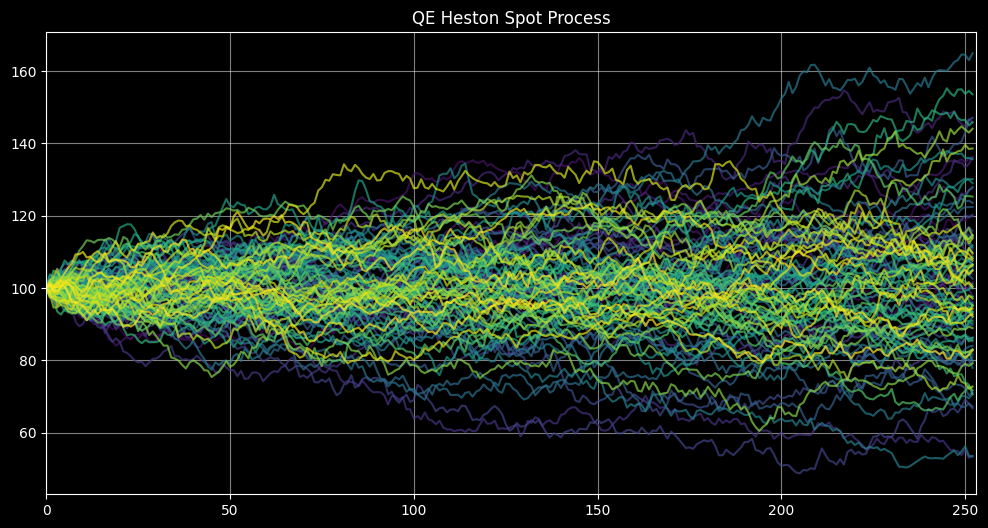

In [137]:
S = heston_sim.spot_values()

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 100)]
plt.figure(figsize=(12, 6))
for i, s in enumerate(S):
    plt.plot(s, color = colors[i], alpha=0.7)
plt.grid(alpha = 0.5)
plt.xlim(0, 253)
plt.title("QE Heston Spot Process")
plt.show()

#### Euler and Dupire

In [113]:
dupire_engine = MonteCarlo(euler_dupire)
dupire_engine.configure(2, -1)

In [132]:
dp_sim = dupire_engine.generate(100, 252, 1, 100)

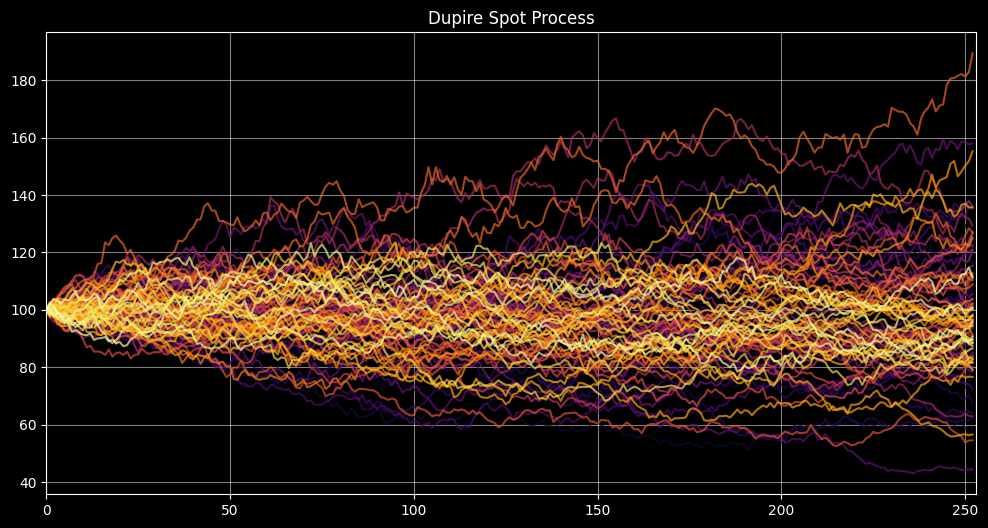

In [136]:

cmap = plt.get_cmap('inferno')
colors = [cmap(i) for i in np.linspace(0, 1, 100)]
plt.figure(figsize=(12, 6))
for i, s in enumerate(dp_sim.spot_values()):
    plt.plot(s, alpha=0.7, color = colors[i])
plt.grid(alpha = 0.5)
plt.xlim(0, 253)
plt.title("Dupire Spot Process")
plt.show()

## Pricing

In [ ]:
from volmc.pricing import Pricer
from volmc.types import MarketState

### Call option

In [152]:
def norm_cdf(x):
    return 0.5 * (1 + np.sign(x) * np.sqrt(1 - np.exp(-2*x**2/np.pi)))

def bs_call_price(S, K, sigma, T, r):
    d1 = (np.log(S/K) + ((sigma**2)/2 + r)*T)/(sigma*np.sqrt(T))
    d2 = d1 - np.sqrt(T)*sigma

    return S* norm_cdf(d1) - K*np.exp(-r*T)*norm_cdf(d2)

In [193]:
r = 0.02
S0 = 110
v0 = 0.25
K = 120
T = 1.4

In [226]:
euler_bs = Euler(BlackScholes(r, v0))
bs_engine = MonteCarlo(euler_bs)
bs_engine.configure(seed = 1, n_jobs = -1)
call = Call(K, T)

p = Pricer(call, bs_engine)
marketstate = MarketState(S0, r)
mc_price = p.price(marketstate, n_steps = 252, n_paths = 100_000)
bs_price = bs_call_price(S0, K, v0,  T, r)

In [227]:
print(f"Black Scholes analytical price : {bs_price:.4f}")
print(f"Monte Carlo simulation price : {mc_price:.4f}")

Black Scholes analytical price : 10.1737
Monte Carlo simulation price : 10.2058


### Digital Put

In [211]:
r = 0.01
S0 = 105
v0 = 0.3
K = 125
T = 1.7

In [212]:
qe = QE(Heston(mu = r,
                kappa = 1.5,
                theta = 0.05,
                epsilon = 0.2,
                rho = -0.5))

qe_engine = MonteCarlo(qe)
qe_engine.configure(seed = 1 , n_jobs = -1)

In [216]:
digitall_put = DigitalPut(K = K, T = T)

engine = Pricer(digital_put, qe_engine)

In [220]:
state = MarketState(S = S0, r = r, v0 = v0)
digital_price = engine.price(marketstate = state, n_steps = 252, n_paths=100_000)

In [222]:
print(f"Heston estimated digital put price : {digital_price:.4f}")

Heston estimated digital put price : 0.3256


### Barrier option

In [201]:
r = 0.02
v0 = 0.2
S0 = 100
K = 110
H = 140

In [202]:
up_out_payoff = Barrier(H, "up", "out", CallPayoff())
up_out_call = Instrument(OptionContract(K = K, T = 1), up_out_payoff)

In [203]:
euler_bs = Euler(BlackScholes(r, v0))
bs_engine = MonteCarlo(euler_bs)
bs_engine.configure(seed = 1, n_jobs = -1)

In [233]:
p = Pricer(up_out_call, bs_engine)
marketstate = MarketState(S0, r)
price = p.price(marketstate = marketstate, n_steps = 1000, n_paths=10_000)

In [234]:
print(f"Estimated Monte Carlo price for this up-and-out call option : {price:.4f}")

Estimated Monte Carlo price for this up-and-out call option : 1.2956
